In [2]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import yaml
from sklearn.linear_model import LogisticRegression


sns.set(rc={'figure.figsize':(15,10)})

In [3]:
## Importation des datas 

market_campaign = pd.read_csv('/home/dancoh/Yotta/Projet/projet1/code/data.csv', delimiter = ',')
socio_eco = pd.read_csv('/home/dancoh/Yotta/Projet/projet1/code/socio_eco.csv', delimiter = ',')

## Remplacement des valeurs manquantes "123" dans AGE

market_campaign.AGE = market_campaign.AGE.replace(123, np.nan)

On trace la matrice des corrélations des variables numériques.

<AxesSubplot:>

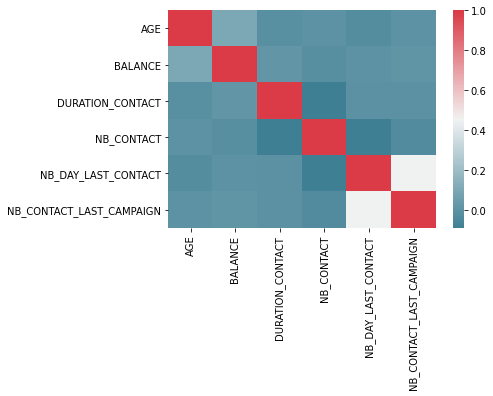

In [3]:
corr = market_campaign.corr()
sns.heatmap(corr, 
    cmap = sns.diverging_palette(220, 10,
    as_cmap=True))

Étude de la feature STATUS (statut marital)
----
Moyenne de Balance par différent statut

<AxesSubplot:xlabel='STATUS', ylabel='BALANCE'>

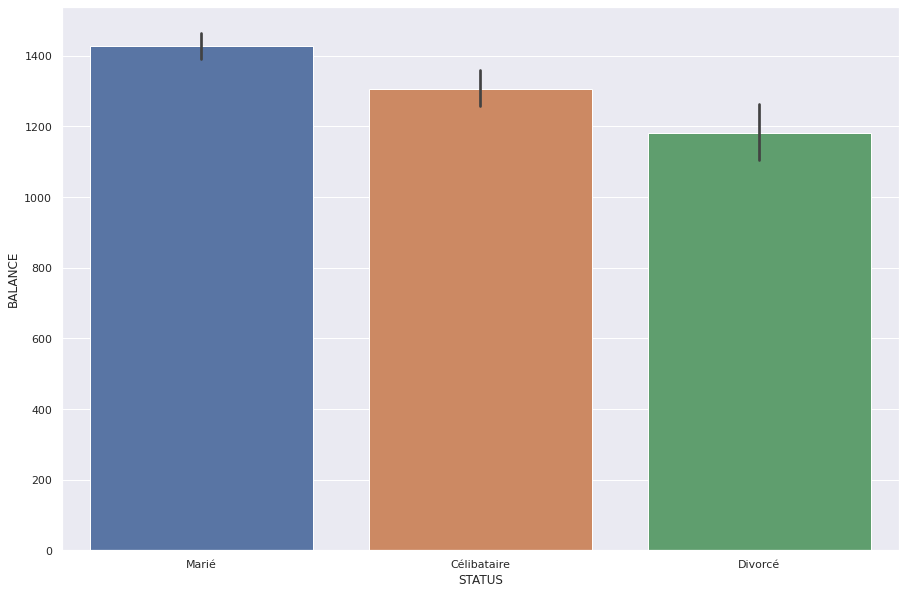

In [7]:
sub_status = market_campaign.dropna(subset = ['STATUS'])

sns.barplot(x = 'STATUS', y = 'BALANCE', data = sub_status)


On remarque aussi que parmi les gens qui ont souscrit, en moyenne la balance est plus haute 

<ipython-input-28-7a099403a05d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subYes = sub_status[market_campaign['SUBSCRIPTION'] =='Yes']
<ipython-input-28-7a099403a05d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subNo = sub_status[market_campaign['SUBSCRIPTION'] =='No']


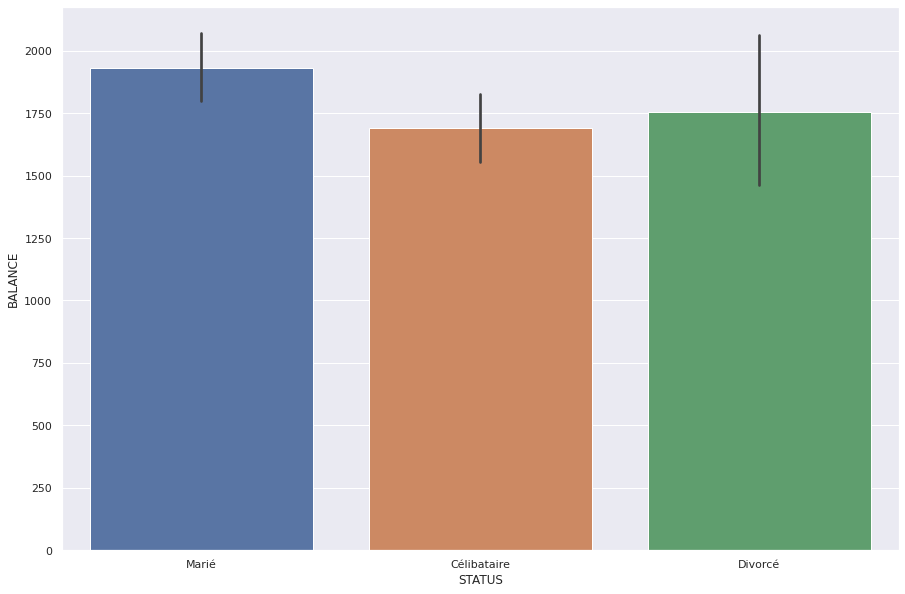

In [28]:
subYes = sub_status[market_campaign['SUBSCRIPTION'] =='Yes']
subNo = sub_status[market_campaign['SUBSCRIPTION'] =='No']

sns.barplot(x = 'STATUS', y = 'BALANCE', data = subYes)
plt.show()

Étude de la feature STATUS (statut marital)
----
On va s'intéresser maintenant à la variable JOB_TYPE

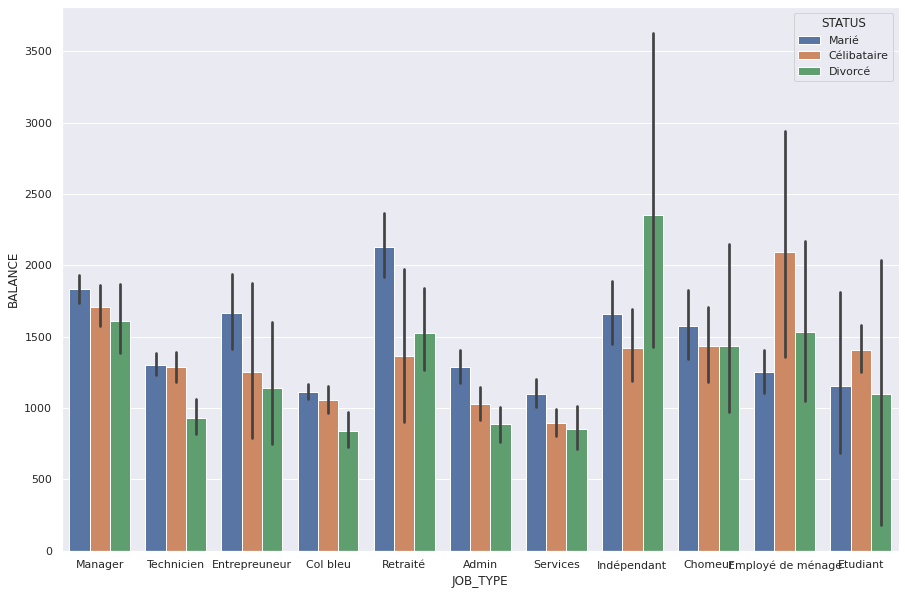

In [21]:
job_type_clean = market_campaign.dropna(subset = ['JOB_TYPE'])

sns.barplot(x = 'JOB_TYPE', y = 'BALANCE', hue = 'STATUS', data = job_type_clean)
plt.show()

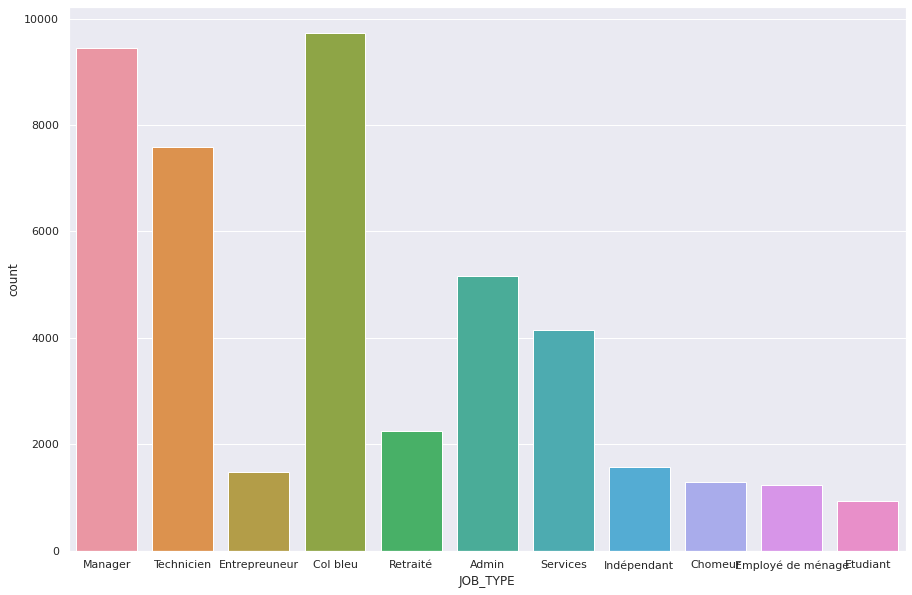

In [18]:
sns.countplot(x = 'JOB_TYPE', data = market_campaign)
plt.show()